## Import Libraries

In [1]:
import pandas as pd
import ast
from collections import defaultdict
from math import sin, cos, sqrt, atan2, radians
import numpy as np
from sklearn.linear_model import LinearRegression

# Task 1

## 1. Import Raw Data and Locate Anomalies

In [2]:
dirty = pd.read_csv("/Users/chengkun/Desktop/5196ass2/31951996_dirty_data.csv")


,sales_id,date,time,shopping_cart,price,parcel_size,Customer_lat,Customer_long,isLoyaltyProgram,nearest_storehouse_id,nearest_storehouse,dist_to_nearest_storehouse,delivery_cost
0,ORD0075570,2021-11-02,15:08:36,"[('wardrobe', 3), ('Chair', 4), ('side_table',...",1518.43,small,-38.13373,145.14894,0,4,Sunshine,41.20,6.4665
1,ORD0084457,13/09/2019,02:28:31,"[('side_table', 4), ('sofa', 1), ('wardrobe', 3)]",1385.05,S,-37.69209,145.80813,0,4,Sunshine,79.89,5.9625
2,ORD0085720,03/12/2020,03:47:13,"[('wardrobe', 1), ('mattress', 1), ('side_tabl...",2035.83,medium,145.83508,-37.47753,1,4,Sunshine,89.41,6.2415
3,ORD0033628,24/07/2021,18:27:59,"[('Study_table', 2), ('Dining_table', 4), ('be...",964.14,S,-38.08069,145.56411,1,4,Sunshine,64.40,6.5745
4,ORD0052321,2018-07-08,17:36:31,"[('side_table', 2), ('Dining_table', 2), ('mat...",3878.50,medium,-37.73802,146.00025,1,4,Sunshine,95.97,6.4125


First of all, we need to list several potential and observed anomalies.
1. Is there any repeated sales_id?
2. Is all the date in same format?
3. Invalid time (eg.29:05:48)
4. Is there any repeated items in shopping cart. (eg.[('side_table', 1), ('side_table', 1)])
5. Invalid price. (eg.S)
6. There are parcel size not in "small, medium, large" (eg.S,M,L)
7. Invalid customer location; possibly inversed latitude and longtitude. (eg.142.69779, -35.81405)
8. Is all loyalty program data either in "True" or "False"?
9. Base on storehouse and customer location, are all the nearest stores correct?
10. Any unmatched storehourse id? 
11. Is delivery_cost correct?

In [3]:
dict_id = {}
for i in dirty.sales_id:
    if i not in dict_id:
        dict_id[i] = 1
    else:
        dict_id[i] += 1

Tranfer all the data of sales_id into dictionary; use id as key, and count of occurrence as item.

In [4]:
len(dict_id) == len(dirty.sales_id)

True

Length of the dictionary and sales_id matches, means no repeat id.

In [5]:
dirty.date[115:125]

115              20/06/2018
116              10/08/2020
117    Thursday 20, 05 2021
118              08/09/2020
119              28/12/2019
120              2021-08-01
121              17/03/2020
122      Sunday 19, 07 2020
123              17/09/2020
124              2018-03-12
Name: date, dtype: object

By checking random date, some invaild format are found. (Sunday 14, 01 2018,2019-12-13)

## 2. Fix Invalid Date Format.

In [6]:
for x,y in dirty.iterrows():
    i = y.date
    if "-" not in i:
        if len(i) == 10:
            day = i[0:2]
            mon = i[3:5]
            year = i[6:10]
            i = day + '-' + mon + '-' +year
        else:
            i = i[-11:]
            day = i[0:2]
            mon = i[4:6]
            year = i[7:11]
            i = day + '-' + mon +'-' + year        
    else: 
        day = i[-2:]
        mon = i[5:7]
        year = i[0:4]
        i = day + '-' + mon +'-' + year
    dirty.loc[x,'date'] = i

day, month and year are selected respectively, and rearranged into corrected format.

## 3. Fix Invalid time.

In [7]:
wrong_time = []
for x,y in dirty.iterrows():
    i = y.time
    hr = int(i[0:2])
    mins = int(i[3:5])
    sec = int(i[6:8])
    if hr >= 24 or mins >= 60 or sec >= 60:
        wrong_time.append(i)  
print(wrong_time[0:8])

['56:07:25', '24:16:59', '32:02:13', '37:23:24', '58:04:38', '47:23:17', '41:15:56', '49:06:36']


Very likely inversed hour and mins.

In [8]:
for x,y in dirty.iterrows():
    i = y.time
    hr = i[0:2]
    mins = i[3:5]
    sec = i[6:8]
    if int(hr) >= 24:               
        new_time = mins + ":" + hr + ":" + sec
        dirty.loc[x,'time'] = new_time

Similar to date, hour, mins and seconds are selected respectively. By using mod, they are valid values now.

In [14]:
count = 0
for i,j in dirty.iterrows():
    lat,long = j.Customer_lat,j.Customer_long
    if long < lat:
        count += 1
count

135

From the dataset, we can tell latitude is a negative value, and longtitude is positive.

So, if a customer`s latitude is bigger than longtitude, the location is invalid.

In [15]:
for i,j in dirty.iterrows():
    lat,long = j.Customer_lat,j.Customer_long
    if long < lat:
        dirty.loc[i,'Customer_lat'] = long
        dirty.loc[i,'Customer_long'] = lat    

In [21]:
def distance(lat1,lon1,lat2,lon2):
    R = 6373.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c 
    return distance

This is a mathematical function to calculate the distance based on geographic location.
I found this function on https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude.

In [22]:
count = 0
wrong_dis = []
for x,y in dirty.iterrows():    
    house = y.nearest_storehouse
    dis = y.dist_to_nearest_storehouse
    lat1,lon1 = y.Customer_lat,y.Customer_long
    lat2,lon2 = houseDict[house]
    dis_cal = distance(lat1,lon1,lat2,lon2)
    if abs(dis - dis_cal)/dis_cal > 0.001:
        count += 1 
        wrong_dis.append(x)
count

73

In [23]:
for x,y in dirty.iterrows():
    if x in wrong_dis:
        short_dis = float('inf')
        lat1,lon1 = y.Customer_lat,y.Customer_long
        for store in houseDict:
            lat2,lon2 = houseDict[store]
            dis_cal = distance(lat1,lon1,lat2,lon2)
            if dis_cal < short_dis:
                short_dis = dis_cal
                dirty.loc[x,'dist_to_nearest_storehouse'] = round(short_dis,2)
                dirty.loc[x,'nearest_storehouse'] = store

In [24]:
count = 0
for x,y in dirty.iterrows():    
    house = y.nearest_storehouse
    dis = y.dist_to_nearest_storehouse
    lat1,lon1 = y.Customer_lat,y.Customer_long
    lat2,lon2 = houseDict[house]
    dis_cal = distance(lat1,lon1,lat2,lon2)
    if abs(dis - dis_cal)/dis_cal > 0.001:
        count += 1 


0

## 1.Import Data

In [26]:
outlier = pd.read_csv("/Users/chengkun/Desktop/5196ass2/31951996_outlier_data.csv")

no outlier in 'nearest_storehouse_id'.

<AxesSubplot:>

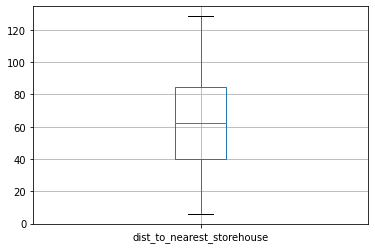

In [35]:
outlier.boxplot(column = 'dist_to_nearest_storehouse')

no outlier in 'dist_to_nearest_storehouse'.

<AxesSubplot:>

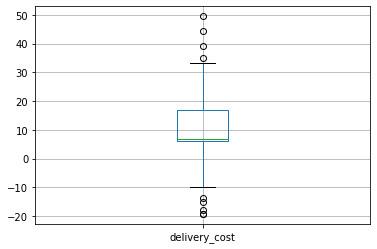

In [36]:
outlier.boxplot(column = 'delivery_cost')

There are outliers in 'delivery_cost'.

In [37]:
len(outlier.delivery_cost)

200

The length of dataframe will be used as comparsion to ensure outliers are removed.

In [38]:
q1, q3 = np.percentile(sorted(outlier.delivery_cost),[25,75])
iqr = q3 - q1
low_limit = q1 -(1.5 * iqr) 
high_limit = q3 +(1.5 * iqr) 

interquartile range (IQR), quartile 1 (Q1) and quartile 3 (Q3) are caculated to locate outliers.

I got the idea from the following website.
https://medium.datadriveninvestor.com/finding-outliers-in-dataset-using-python-efc3fce6ce32

In [39]:
count = 0
for x,y in outlier.iterrows():
    cost = y.delivery_cost
    if cost > high_limit or cost < low_limit:
        outlier = outlier.drop(x)
        count += 1
count

9

Any value bigger than upper limit or smaller than lower limit will be removed.

In [40]:
len(outlier.delivery_cost)

191

200 - 9 = 191, all outliers are removed.

In [41]:
missing = pd.read_csv("/Users/chengkun/Desktop/5196ass2/31951996_missing_data.csv")

Import CSV file

In [43]:
for x,y in missing.iterrows():
    for i in item_dict:
        total_price = 0
        cart = y.shopping_cart
        each = ast.literal_eval(cart)
        for j in each:
            total_price += (item_dict[j[0]])*j[1]
            missing.loc[x,'price'] = round(total_price,2)

In [45]:
for x,y in missing.iterrows():
    if y.isLoyaltyProgram == True:
        missing.loc[x,'cost_cal'] = y.delivery_cost/0.9
    else:
        missing.loc[x,'cost_cal'] = y.delivery_cost

Add three new columns to the dataframe to help build linear regression, where 'cost_cal' is the real cost before discount.

In [46]:
missing.loc[missing.date.apply(lambda x: x.split('/')[1] in ['12','01','02']),'season'] = 1
missing.loc[missing.date.apply(lambda x: x.split('/')[1] in ['03','04','05']),'season'] = 2
missing.loc[missing.date.apply(lambda x: x.split('/')[1] in ['06','07','08']),'season'] = 3
missing.loc[missing.date.apply(lambda x: x.split('/')[1] in ['09','10','11']),'season'] = 4
missing.loc[missing.parcel_size == 'small','parcel'] = 1
missing.loc[missing.parcel_size == 'medium','parcel'] = 2
missing.loc[missing.parcel_size == 'large','parcel'] = 3

Write values into the empty columns.
In 'season':
'1' for Summer;
'2' for Autumn;
'3' for Winter;
'4' for Spring.

In 'parcel':
'1' for small;
'2' for medium;
'3' for big.

'dist_to_nearest_storehouse','season','parcel','nearest_storehouse_id' and 'isLoyaltyProgram' are assumed to be the factors that affect delivery price.

Check if the new columns are filled with correct value

find the index for empty value, and store them into a list "miss_index".

In [49]:
values = missing.dropna()

find the rows that do not have a missing value.

In [50]:
x = values[['dist_to_nearest_storehouse','season','parcel','nearest_storehouse_id']]
y = values.cost_cal
reg = LinearRegression().fit(x,y)
reg.score(x,y)

0.7392540288171507

calculate the score for Linear Regression, 0.74 is a fair number (1 means perfect linear)

write the predict value into the dataframe, if a customer is in  LoyaltyProgram, he/she get 10% off.

In [52]:
for x,y in missing.iterrows():
    if x in miss_index:
        print(y.delivery_cost)

7.497232311542465
6.546758206327447
6.5715223638147515
6.212567875735545
6.120809279472726
7.528383121717916
6.774602161703918
7.291705383717986
6.135014660294502
6.1871192389440495
7.091297876448131
16.93458320581663
19.225415875256225
5.706457798469648
6.192341751179019
16.393620942518588


Check the written missing value.

## Reference
https://www.geeksforgeeks.org/python-join-tuples-if-similar-initial-element/
    
https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/

https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude